In [1]:
import glob
from hera_qm import xrfi as xrfi
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import numpy as np
import numpy.ma as ma
import os
import itertools as it
from pyuvdata import UVData
import sys
import json
np.set_printoptions(threshold='nan')


In [19]:
Data_Path='/lustre/aoc/projects/hera/djacobs/IDR2_flags/2458035'
#This will take in a data path and output the arrays needed to plot the flags.
#init variables
file_flag_xx=[]
file_flag_yy=[]
time_mean_xx=[]
time_mean_yy=[]
time_mean_xx_old=[]
time_mean_yy_old=[]
flag_times_xx=[]
flag_times_yy=[]
chan_mean_xx=[]
chan_mean_yy=[]
chan_mean_xx_old=[]
chan_mean_yy_old=[]
flag_waterfall_xx=[]
flag_waterfall_yy=[]
xants_xx=[]
xants_yy=[]
SUMMARY_PATH='/lustre/aoc/projects/hera/dlewis/FullSeason_flag_summaries'
JSON_PATH='/lustre/aoc/projects/hera/dlewis/ant_metrics_fullseason'

#Gather flags
#xx
file_flag_xx=glob.glob(Data_Path + '/*.xx.*.uvO.flags.npz')
file_flag_xx.sort()
#yy
file_flag_yy=glob.glob(Data_Path + '/*.yy.*.uvO.flags.npz')
file_flag_yy.sort()

for i,flagfile in enumerate(file_flag_xx):
    directory=os.path.split(Data_Path)[1]
    JD=flagfile[-33:-20]
    print ('Accessing: '+ JD)
    #load JSON for given JD
    jsontemp=JSON_PATH + '/' + directory +'/zen.' + JD + '.HH.uv.ant_metrics.json'
    with open(jsontemp,'r') as antjson:
        antmetrics=json.load(antjson)
    #copy into better format
    exec('ants='+antmetrics['xants']) 
    #get xants for polarization
    xants_xx_temp=np.asarray([xant for i, (xant,pol) in enumerate(ants) if pol=='x'])
    xants_xx.extend(xants_xx_temp)
    print ('xants_xx_temp='+str(xants_xx_temp))
    numxant=len(xants_xx_temp)
    print ('numxant='+str(numxant))
    #load summary data
    sum_data=np.load(SUMMARY_PATH + '/' + directory +'/zen.' + JD + '.xx.HH.uvO.flag_summary.npz')
    flag_times_xx.extend(sum_data['times'])
    #load flag data
    flag_data=np.load(flagfile)
    
    timelen=len(flag_data['waterfall'])
    print ('timelen='+str(timelen))
    
    numbaseline=len(flag_data['flag_array'])/timelen
    print ('numbaseline 1='+str(numbaseline))
    
    numant=(np.sqrt((8*numbaseline) +1) -1)/2
    print ('numant='+str(numant))
    
    antcomb=it.combinations_with_replacement(np.linspace(1, numant,numant, endpoint=True), 2)
    noxantcomb=it.combinations_with_replacement(np.linspace(1, numant-numxant,numant-numxant, endpoint=True), 2)
    baselines=list(antcomb) #list of baselines
    goodbase=list(noxantcomb) #list of baselines not including xants
    numbase=len(baselines) #Nbls
    numgoodbase=len(goodbase) #Nbls not including xants
    numxantbase=numbase-numgoodbase #Nbls of xant baselines
    print ('numbaseline 2='+str(numbase))
    print ('numgoodbaselines='+str(numgoodbase))
    print ('numxantbaselines='+str(numxantbase))
    
    #current shape of flag_array: (Nblts, Nspw, Nchans, Npols)
    
    #compute base sums first
    basearr=np.reshape(flag_data['flag_array'],(timelen, numbaseline, 1, 1024, 1)) #convert shape to (Ntimes, Nbls, Nspws, Nfreqs, Npols)
    print basearr.shape
    basesum=np.sum(basearr, axis=1)  #sum over Nbls
    print basesum.shape
    baseavg=(basesum-numxantbase)/(numbaseline-numxantbase) #average over Nbls minus xant baselines
    print baseavg.shape #shape is now (Ntimes, Nspws, Nfreqs, Npols)
    
    
    #time averaging
    time_mean_temp=np.mean(baseavg,axis=(0,1,3)) #average  over Ntimes, Nspw, Npols
#     time_temp=np.reshape(time_mean_temp,(timelen, numbaseline, 1024))
#     timesums=np.sum(time_temp, axis=1)
#     timeavgxant=(timesums-numxantbase)/(numbaseline-numxantbase)
    print time_mean_temp.shape
#     print timeavgxant.shape
    time_mean_xx.append(time_mean_temp)
    
    #channel averaging
    chan_mean_temp=np.mean(baseavg, axis=(1,2,3))
#     chantemp=np.reshape(chan_mean_temp,(timelen, numbaseline))#reshape to a more flexible shape
#     chansums=np.sum(chantemp, axis=1)
#     chanavgxant=(chansums-numxantbase)/(numbaseline-numxantbase) #subtract flagged antennas from sum over baseline averaging
    chan_mean_xx.extend(chan_mean_temp)
    
    #Old version, without subtracting flagged antennas
    time_mean_xx_old.append(np.mean(flag_data['flag_array'], axis=(0,1,3)))
    chan_mean_temp_old=np.mean(flag_data['flag_array'], axis=(1,2,3))
    chantemp_old=np.reshape(chan_mean_temp_old,(timelen, numbaseline))
    chan_mean_xx_old.extend(np.mean(chantemp_old, axis=1))
    
for i,flagfile in enumerate(file_flag_yy):
    directory=os.path.split(Data_Path)[1]
    JD=flagfile[-33:-20]
    print ('Accessing: '+ JD)
    #load JSON for given JD
    jsontemp=JSON_PATH + '/' + directory +'/zen.' + JD + '.HH.uv.ant_metrics.json'
    with open(jsontemp,'r') as antjson:
        antmetrics=json.load(antjson)
    #copy into better format
    exec('ants='+antmetrics['xants']) 
    #get xants for polarization
    xants_yy_temp=np.asarray([xant for i, (xant,pol) in enumerate(ants) if pol=='y'])
    xants_yy.extend(xants_yy_temp)
    print ('xants_yy_temp'+str(xants_yy_temp))
    numxant=len(xants_yy_temp)
    print 'numxant=' +str(numxant)
    #load summary data
    sum_data=np.load(SUMMARY_PATH + '/' + directory +'/zen.' + JD + '.yy.HH.uvO.flag_summary.npz')
    flag_times_yy.extend(sum_data['times'])
    #load flag data
    flag_data=np.load(flagfile)
    
    timelen=len(flag_data['waterfall'])
    print 'timelen='+str(timelen)
    
    numbaseline=len(flag_data['flag_array'])/timelen
    print 'numbaseline='+str(numbaseline)
    
    numant=(np.sqrt((8*numbaseline) +1) -1)/2
    print 'numant='+str(numant)
    
    antcomb=it.combinations_with_replacement(np.linspace(1, numant,numant, endpoint=True), 2)
    noxantcomb=it.combinations_with_replacement(np.linspace(1, numant-numxant,numant-numxant, endpoint=True), 2)
    baselines=list(antcomb) #list of baselines
    goodbase=list(noxantcomb) #list of baselines not including xants
    numbase=len(baselines) #Nbls
    numgoodbase=len(goodbase) #Nbls not including xants
    numxantbase=numbase-numgoodbase #Nbls of xant baselines
    print ('numbaseline 2='+str(numbase))
    print ('numgoodbaselines='+str(numgoodbase))
    print ('numxantbaselines='+str(numxantbase))
    
    #current shape of flag_array: (Nblts, Nspw, Nchans, Npols)
    
    #compute base sums first
    basearr=np.reshape(flag_data['flag_array'],(timelen, numbaseline, 1, 1024, 1)) #convert shape to (Ntimes, Nbls, Nspws, Nfreqs, Npols)
    print basearr.shape
    basesum=np.sum(basearr, axis=1)  #sum over Nbls
    print basesum.shape
    baseavg=(basesum-numxantbase)/(numbaseline-numxantbase) #average over Nbls minus xant baselines
    print baseavg.shape #shape is now (Ntimes, Nspws, Nfreqs, Npols)
    
    #time averaging
    time_mean_temp=np.mean(baseavg,axis=(0,1,3)) #average  over Ntimes, Nspw, Npols
#     time_temp=np.reshape(time_mean_temp,(timelen, numbaseline, 1024))
#     timesums=np.sum(time_temp, axis=1)
#     timeavgxant=(timesums-xantbaselines)/(numbaseline-xantbaselines)
    
    print time_mean_temp.shape
    
    time_mean_yy.append(time_mean_temp)
    
    #channel averaging
    chan_mean_temp=np.mean(baseavg, axis=(1,2,3))
#     chantemp=np.reshape(chan_mean_temp,(timelen, numbaseline))#reshape to a more flexible shape
#     chansums=np.sum(chantemp, axis=1)
#     chanavgxant=(chansums-xantbaselines)/(numbaseline-xantbaselines) #subtract flagged antennas from sum over baseline averaging
    chan_mean_yy.extend(chan_mean_temp)
    
    
    
    
    #Old version, without subtracting flagged antennas
    time_mean_yy_old.append(np.mean(flag_data['flag_array'], axis=(0,1,3)))
    chan_mean_temp_old=np.mean(flag_data['flag_array'], axis=(1,2,3))
    chantemp_old=np.reshape(chan_mean_temp_old,(timelen, numbaseline))
    chan_mean_yy_old.extend(np.mean(chantemp_old, axis=1))    


xants_xx=np.unique(xants_xx)
xants_yy=np.unique(xants_yy)
timeshape=np.asarray(time_mean_xx)
print timeshape.shape
time_mean_xx_old=np.mean(time_mean_xx_old, axis=0)
time_mean_xx=np.mean(time_mean_xx, axis=0)
time_mean_yy_old=np.mean(time_mean_yy_old, axis=0)
time_mean_yy=np.mean(time_mean_yy, axis=0)



Accessing: 2458035.16718
xants_xx_temp=[121  70]
numxant=2
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)


/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


Accessing: 2458035.17464
xants_xx_temp=[121  70]
numxant=2
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.18209
xants_xx_temp=[121  70]
numxant=2
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.18955
xants_xx_temp=[121  70]
numxant=2
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.19701
xants_xx_temp=[121  70  51  50  66  83  65  98 120 122 124 123 143 141]
numxant=14
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.20446
xants_xx_temp=[121

numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.40579
xants_xx_temp=[121  50  70 143 124 141  83 122 123  51 120  65  66  98 142]
numxant=15
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.41325
xants_xx_temp=[121  70 143 124  50  51 123 122  83 120  65  66  98 141 142]
numxant=15
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.42070
xants_xx_temp=[121  70  50  51 143 141 124 123  65 122 120  83  98  66]
numxant=14
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessi

numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.62949
xants_xx_temp=[121  70  51  50  66  65  83  98 120 122 124 141 143 123 142]
numxant=15
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.63694
xants_xx_temp=[121  70  51 124 143 141 123 122  83 120  66  65  98  50 142  82]
numxant=16
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=496
numxantbaselines=632
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.64440
xants_xx_temp=[121  70  51 124  50 143 141 123 122  83 120  66  65  98 142]
numxant=15
timelen=60
numbaseline 1=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)

/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:137: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
/lustre/aoc/projects/hera/env/lib/python2.7/site-packages/ipykernel_launcher.py:138: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.17464
xants_yy_temp[121  70]
numxant=2
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.18209
xants_yy_temp[121  70]
numxant=2
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.18955
xants_yy_temp[121  70]
numxant=2
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=1035
numxantbaselines=93
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.19701
xants_yy_temp[121  70  51  50  66  83  65  98 120 122 124 123 143 141]
numxant=14
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 24

(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.40579
xants_yy_temp[ 70 121 143 124 141  83 122 123  51 120  65  66  98  50   2 142]
numxant=16
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=496
numxantbaselines=632
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.41325
xants_yy_temp[121  70 143 124 141  50  51 123 122  83 120  65  66  98   2]
numxant=15
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=528
numxantbaselines=600
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.42070
xants_yy_temp[121  70  50  51 143 141 124 123  65 122 120  83  98  66]
numxant=14
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.42816
xants_yy_temp[121  70  51  66  65  83  98 120 143 141 122 123 124  50]
numxant=14
timelen=60
numbaseli

Accessing: 2458035.62949
xants_yy_temp[ 70  51  66  65  83  98 120 122 124 141 143 123 121  50]
numxant=14
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.63694
xants_yy_temp[121  70  51 124 143 141 123 122  83 120  66  65  98  50 142  82]
numxant=16
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=496
numxantbaselines=632
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.64440
xants_yy_temp[121  70  51 124 143 141 123 122  83 120  66  65  98  50]
numxant=14
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgoodbaselines=561
numxantbaselines=567
(60, 1128, 1, 1024, 1)
(60, 1, 1024, 1)
(60, 1, 1024, 1)
(1024,)
Accessing: 2458035.65186
xants_yy_temp[ 70  51 124 121 122 123 143 141  83 120  66  65  98  50]
numxant=14
timelen=60
numbaseline=1128
numant=47.0
numbaseline 2=1128
numgood

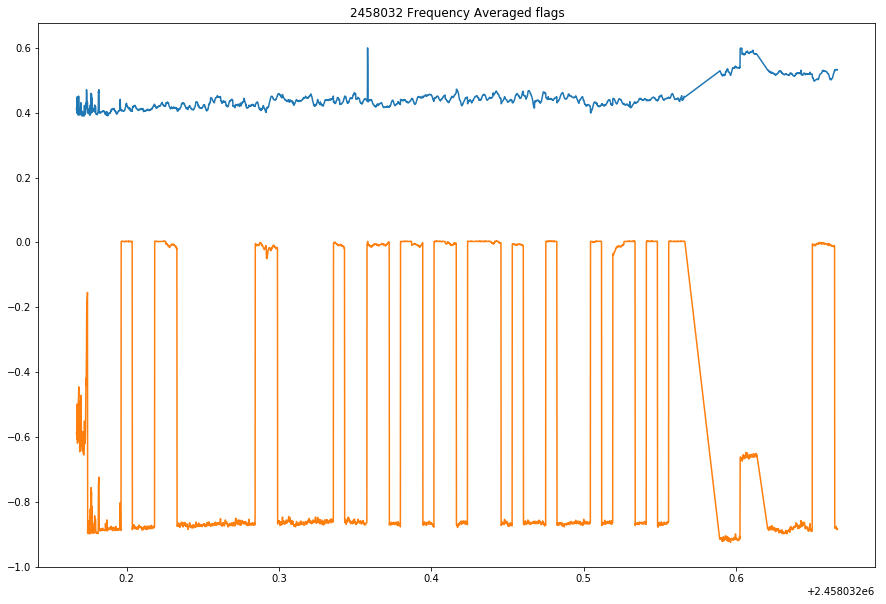

In [17]:
plt.figure(figsize=(15,10))
plt.title(str(directory) + ' Frequency Averaged flags')
plt.plot(flag_times_xx,chan_mean_yy_old, label='Old (including xants)')
plt.plot(flag_times_xx, chan_mean_yy, label='New (minus xants)')

# plt.ylim(-0.1,1.1)
plt.show()


In [ ]:
print xants_xx
# print xants_yy

In [ ]:
print basesum

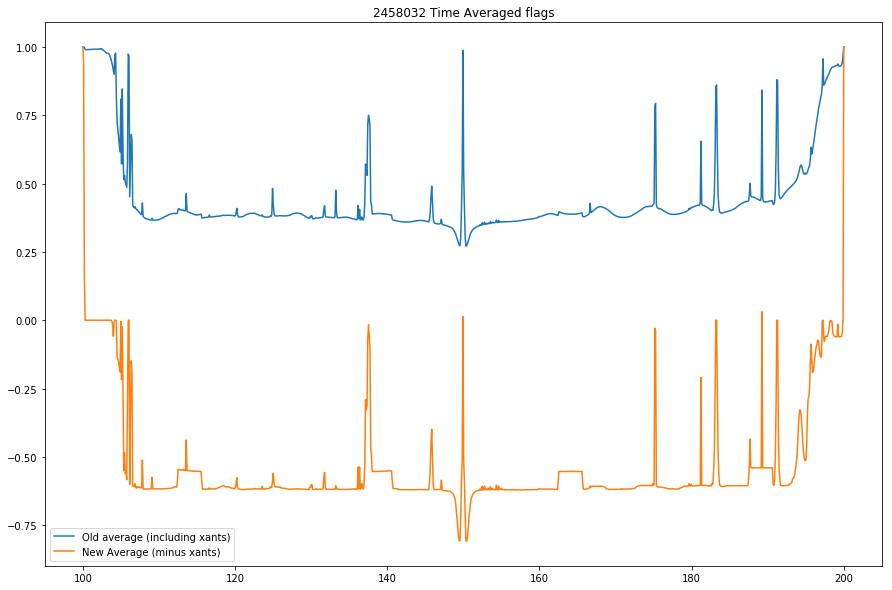

In [18]:

freqs=np.linspace(100, 200, num=1024)
plt.figure(figsize=(15,10))
plt.title(str(directory) + ' Time Averaged flags')
plt.plot(freqs,time_mean_yy_old, label='Old average (including xants)')
plt.plot(freqs,time_mean_yy, label='New Average (minus xants)')
plt.legend()
# plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
numants=5
numxants=2
numbaselines=(numants*(numants+1))/2
numxbase=(numxants*(numxants+1))/2
testsum=0
a=np.linspace(1, 10,10, endpoint=True)

goodbase=((numants-numxants)*(numants-numxants +1))/2
print testsum
print goodbase
print numbaselines
print numxbase
print numbaselines-goodbase

In [ ]:
antcomb=it.combinations_with_replacement(np.linspace(1, numants,numants, endpoint=True), 2)
noxantcomb=it.combinations_with_replacement(np.linspace(1, numants-numxants,numants-numxants, endpoint=True), 2)
baselines=list(antcomb)
goodbaselines=list(noxantcomb)
numbaselines=len(baselines)
numgoodbaselines=len(goodbaselines)
numbadbaselines=numbaselines-numgoodbaselines
print numbaselines
print numgoodbaselines
print numbadbaselines

In [ ]:
a=[[0],[0],[0],[1],[0],[1],[1],[0],[1],[1],[1],[0],[1],[1],[1],[0],[1],[1],[1],[0],[1],[0],[1],[0],[1],[1],[0],[0],[0],[1]]
b=np.asarray(a)
c=np.reshape(b, (3,10,1))
d=np.sum(c, axis=1)-1
e=d/(10.0-1.0)
print b
print c
print d
print e

In [ ]:
'''
To Do:
======
[*]plot single JD normally, then without flagged antennas
[*]fix equation for flag antennas to include ALL xant baselines (not just xants/xants)
    [*]Get Nants
[ ]
'''